# Fixed Effect Regressions (Industry and Country) to Explain Environmental Intensity (Environmental Costs/Sales) in Python


In this notebook, we will present three fixed effects based on:

1) Industry
2) Country
3) Industry and Country

First, we will clean this new dataset and gather the necessary columns for our analysis. Let's start by importating necessary libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings('ignore')

We read in the dataframe and clean out the column names

In [5]:
df = pd.read_csv('Final-Sample-External-with-ISINs.csv')


column_list = []
for column in df.columns:
    column_list.append(column.replace(' ', ''))
df.columns = column_list
df.head()

,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),EnvironmentalIntensity(OpInc),TotalEnvironmentalCost,WorkingCapacity,FishProductionCapacity,...,SDG6,SDG12.2,SDG14.1,SDG14.2,SDG14.3,SDG14.c,SDG15.1,SDG15.2,SDG15.5,%Imputed
0,GB00BMX64W89,2019,Saga plc,United Kingdom,Activities auxiliary to financial intermediati...,-2.89%,-13.03%,"(31,842,309)","(31,150,754)","(7,184)",...,"(170,776)","(1,059)",(5),(1),"(3,585)",(6),71,71,"(1,297)",1%
1,MYL1818OO003,2019,BURSA MALAYSIA BHD,Malaysia,Activities auxiliary to financial intermediati...,-1.68%,-3.47%,"(1,968,379)","(1,924,910)",(451),...,"(11,502)",(168),(1),(1),(222),(2),10,10,(79),4%
2,GB0031638363,2019,INTERTEK GROUP PLC,United Kingdom,Activities auxiliary to financial intermediati...,-1.53%,-9.49%,"(60,599,272)","(59,281,663)","(13,774)",...,"(324,960)","(3,804)",(17),(4),"(6,861)",(20),254,254,"(2,470)",1%
3,ZAE000079711,2019,JSE LIMITED,South Africa,Activities auxiliary to financial intermediati...,-1.46%,NaN,"(2,290,124)","(2,239,814)",(510),...,"(12,200)",(901),(0),(1),(253),(0),(3),(3),(93),2%
4,FR0006174348,2019,BUREAU VERITAS SA,France,Activities auxiliary to financial intermediati...,-0.70%,-5.10%,"(39,978,650)","(39,107,612)","(9,330)",...,"(214,438)","(4,116)",(38),(9),"(4,607)",(45),586,586,"(1,633)",3%


We are only interested in the columns Year, Country, Industry(Exiobase), Environmental Intensity (Sales), Total Enviromental Cost. Also, we will format these last two columns to float.

In [3]:
df = df[['Year', 'Country', 'Industry(Exiobase)', 'EnvironmentalIntensity(Sales)', 'TotalEnvironmentalCost']]

def percent_to_float(s):
    return float(s.strip('%')) / 100.0

replace_dict = {'(':'',')':'', ' ' : '', ',' : ''}
def paranthesis_to_minus(value):
    for i, j in replace_dict.items():
        value = value.replace(i, j)
    value = int(f'-{value}')
    return value

df['EnvironmentalIntensity(Sales)'] = df['EnvironmentalIntensity(Sales)'].apply(percent_to_float)
df['TotalEnvironmentalCost'] = df['TotalEnvironmentalCost'].apply(paranthesis_to_minus)
df['Revenue'] = df['TotalEnvironmentalCost'] / df['EnvironmentalIntensity(Sales)']
df.rename(columns={'Industry(Exiobase)':'Ind','EnvironmentalIntensity(Sales)' : 'Environmental_Intensity'},inplace=True)


print(f'The dataset contains information for {len(df.Country.unique())} countries and {len(df.Ind.unique())} industries from {df.Year.min()} to {df.Year.max()}')
df.head()

The dataset contains information for 129 countries and 111 industries from 2010 to 2019


,Year,Country,Ind,Environmental_Intensity,TotalEnvironmentalCost,Revenue
0,2019,United Kingdom,Activities auxiliary to financial intermediati...,-0.0289,-31842309,1.101810e+09
1,2019,Malaysia,Activities auxiliary to financial intermediati...,-0.0168,-1968379,1.171654e+08
2,2019,United Kingdom,Activities auxiliary to financial intermediati...,-0.0153,-60599272,3.960737e+09
3,2019,South Africa,Activities auxiliary to financial intermediati...,-0.0146,-2290124,1.568578e+08
4,2019,France,Activities auxiliary to financial intermediati...,-0.0070,-39978650,5.711236e+09


We proceed to create dummy variables for industry and country.

In [4]:
df.Ind = df.Ind.astype('category')
df.Country = df.Country.astype('category')
df['Ind_cat'] = df.Ind.cat.codes
df['Country_cat'] = df.Country.cat.codes
df.head(3)

,Year,Country,Ind,Environmental_Intensity,TotalEnvironmentalCost,Revenue,Ind_cat,Country_cat
0,2019,United Kingdom,Activities auxiliary to financial intermediati...,-0.0289,-31842309,1.101810e+09,55,127
1,2019,Malaysia,Activities auxiliary to financial intermediati...,-0.0168,-1968379,1.171654e+08,55,98
2,2019,United Kingdom,Activities auxiliary to financial intermediati...,-0.0153,-60599272,3.960737e+09,55,127


We concluded with a dataset with the following variables:

* Year = Year of data
* Country_cat = Country Code created to represent each unique country
    - We will drop the 'Country' column and use this one instead
* Ind_cat = Industry Code (1-50) created to represent
    - We will drop the 'Ind' column and use this one instead
* Enviromental_Intensity = Environmental Costs/Sales in 2019
* TotalEnvironmentalCost = Total Environmental Costs in US dollars
* Revenue = Sales in US dollars for each year (derived from "Enviromental_Intensity" and "Total Enviromental Cost")



We need to consider to have at least three companies for each industry. The main reason is to make the fixed effect representative and useful. By measuring only one company in one industry, the fixed effect for industry won't be really aplicable. 

In [5]:
grouped_by = df.groupby('Ind')[['Ind_cat']].count().reset_index()
grouped_by.columns = ['Industry','Number_of_companies']
data = grouped_by.loc[grouped_by.Number_of_companies <=  3, ].sort_values(by='Number_of_companies')
data.head()

,Industry,Number_of_companies
63,Cultivation of cereal grains nec,1
68,"Forestry, logging and related service activiti...",1
64,Education (80),2
107,Sea and coastal water transport,2


We won't consider this four industries in our model which means that we are only including 107 industries. 

In [6]:
grouped_by = df.groupby('Country')[['Country_cat']].count().reset_index()
grouped_by.columns = ['Country','Number_of_companies']
data = grouped_by.loc[grouped_by.Number_of_companies <=  3, ].sort_values(by='Number_of_companies')
data.head()

,Country,Number_of_companies
101,Morocco,1
106,Pakistan,1
81,Gibraltar,1
76,Faeroe Island,1
30,Kuwait,1


In [7]:
industries = ['Cultivation of cereal grains nec','Forestry, logging and related service activities (02)','Education (80)','Sea and coastal water transport']
countries = ['Morocco', 'Pakistan','Gibraltar','Faeroe Island','Kuwait']
df = df[~df.Ind.isin(industries)]
df = df[~df.Country.isin(countries)]
print(f'Now, we are only considering {len(df.Ind.unique())} industries and {len(df.Country.unique())} countries for fixed effects')

Now, we are only considering 107 industries and 124 countries for fixed effects


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14498 entries, 0 to 14514
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Year                     14498 non-null  int64   
 1   Country                  14498 non-null  category
 2   Ind                      14498 non-null  category
 3   Environmental_Intensity  14498 non-null  float64 
 4   TotalEnvironmentalCost   14498 non-null  int64   
 5   Revenue                  14498 non-null  float64 
 6   Ind_cat                  14498 non-null  int8    
 7   Country_cat              14498 non-null  int16   
dtypes: category(2), float64(2), int16(1), int64(2), int8(1)
memory usage: 661.3 KB


Now, we will proceed to work with the fixed effects models. 

## Baseline Regression
* Estimate a regression: *er = constant*
* The coefficient estimate will give the average Environmental Intenisty for the 14,509 firms

In [9]:
df['constant'] = 1

X = df[['constant']]
y = df['Environmental_Intensity']

sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Environmental_Intensity   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                       nan
Date:                     Mon, 10 May 2021   Prob (F-statistic):                nan
Time:                             15:14:59   Log-Likelihood:                -1653.6
No. Observations:                    14498   AIC:                             3309.
Df Residuals:                        14497   BIC:                             3317.
Df Model:                                0                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.1130      0.002    -50.180      0.000      -0.117      -0.109
==============================================================================
Omnibus:                    10328.844   Durbin-Watson:                   0.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178425.119
Skew:                          -3.291   Prob(JB):                         0.00
Kurtosis:                      18.876   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As expected, the R-squared and Adj. R-squared are zero because we don't have any features that could explain the environmental intesity. 

From this regression, we are interested to about the constant coefficient which tells us that the average environmental intesity is around -0.1131 when everything else is constant and we don't have any explanatory variables. 

## Industry fixed effect

Now, we are interested in the industry fixed effect and see how much of the environmental intensity variation can be explained based on the company industry. 


We will drop unnecessary columns, and create some dummy variables for the countries. 

In [10]:
df.drop(columns=['Country','Ind'], inplace=True)
df_ind = df.copy()
df_ind = pd.get_dummies(df_ind, columns=['Ind_cat'])
df_ind

,Year,Environmental_Intensity,TotalEnvironmentalCost,Revenue,Country_cat,constant,Ind_cat_0,Ind_cat_1,Ind_cat_2,Ind_cat_3,...,Ind_cat_100,Ind_cat_101,Ind_cat_102,Ind_cat_103,Ind_cat_104,Ind_cat_105,Ind_cat_106,Ind_cat_108,Ind_cat_109,Ind_cat_110
0,2019,-0.0289,-31842309,1.101810e+09,127,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019,-0.0168,-1968379,1.171654e+08,98,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019,-0.0153,-60599272,3.960737e+09,127,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019,-0.0146,-2290124,1.568578e+08,116,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019,-0.0070,-39978650,5.711236e+09,78,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14510,2010,-0.0171,-259674701,1.518566e+10,28,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14511,2010,-0.0139,-164612070,1.184259e+10,28,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14512,2010,-0.0101,-38125940,3.774846e+09,61,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14513,2010,-0.0042,-21863235,5.205532e+09,50,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X = df_ind.iloc[:,6:]
y = df_ind['Environmental_Intensity']


sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Environmental_Intensity   R-squared:                       0.432
Model:                                 OLS   Adj. R-squared:                  0.427
Method:                      Least Squares   F-statistic:                     103.0
Date:                     Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                             15:14:59   Log-Likelihood:                 2440.3
No. Observations:                    14498   AIC:                            -4667.
Df Residuals:                        14391   BIC:                            -3855.
Df Model:                              106                                         
Covariance Type:                 nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Ind_cat_0      -0.0052      0.016     -0.329      0.742      -0.036       0.026
Ind_cat_1      -0.1176      0.018     -6.455      0.000      -0.153      -0.082
Ind_cat_2      -0.1955      0.019    -10.304      0.000      -0.233      -0.158
Ind_cat_3      -0.1418      0.013    -10.637      0.000      -0.168      -0.116
Ind_cat_4      -0.1125      0.036     -3.101      0.002      -0.184      -0.041
Ind_cat_5      -0.0075      0.012     -0.636      0.525      -0.030       0.016
Ind_cat_6      -0.0424      0.010     -4.334      0.000      -0.062      -0.023
Ind_cat_7      -0.3120      0.059     -5.266      0.000      -0.428      -0.196
Ind_cat_8      -0.0162      0.103     -0.158      0.875      -0.217       0.185
Ind_cat_9      -0.1980      0.013    -15.820      0.000      -0.222      -0.173
Ind_cat_10     -0.2192      0.029     -7.552      0.000      -0.276      -0.162
Ind_cat_11     -0.0201      0.007     -2.761      0.006      -0.034      -0.006
Ind_cat_12     -0.1635      0.103     -1.593      0.111      -0.365       0.038
Ind_cat_13     -0.0191      0.036     -0.528      0.598      -0.090       0.052
Ind_cat_14     -0.0017      0.021     -0.083      0.934      -0.043       0.039
Ind_cat_15     -0.7143      0.038    -18.741      0.000      -0.789      -0.640
Ind_cat_16     -0.0428      0.017     -2.540      0.011      -0.076      -0.010
Ind_cat_17     -0.0632      0.010     -6.355      0.000      -0.083      -0.044
Ind_cat_18     -0.0222      0.013     -1.699      0.089      -0.048       0.003
Ind_cat_19     -0.2378      0.057     -4.177      0.000      -0.349      -0.126
Ind_cat_20     -0.0356      0.015     -2.400      0.016      -0.065      -0.007
Ind_cat_21     -0.0173      0.011     -1.534      0.125      -0.039       0.005
Ind_cat_22     -0.0064      0.015     -0.434      0.665      -0.035       0.023
Ind_cat_23     -0.0147      0.013     -1.098      0.272      -0.041       0.012
Ind_cat_24     -0.0252      0.017     -1.521      0.128      -0.058       0.007
Ind_cat_25     -0.0324      0.024     -1.349      0.177      -0.079       0.015
Ind_cat_26     -0.1577      0.047     -3.348      0.001      -0.250      -0.065
Ind_cat_27     -0.0699      0.057     -1.227      0.220      -0.181       0.042
Ind_cat_28     -0.0372      0.045     -0.831      0.406      -0.125       0.051
Ind_cat_29     -0.2306      0.015    -15.487      0.000      -0.260      -0.201
Ind_cat_30     -0.5455      0.073     -7.517      0.000      -0.688      -0.403
Ind_cat_31     -0.3063      0.018    -16.687      0.000      -0.342      -0.270
Ind_cat_32     -0.3013      0.041     -7.339      0.000      -0.382      -0.221
Ind_cat_33     -0.0410      0.026     -1.561      0.119      -0.093       0.010
Ind_cat_34     -0.0519      0.012     -4.429      0.000      -0.075 

From this summary results, we can see that 43% of the environmental intensity can be explained by company industry. Based on these results, we notice the importance between the firm business operations and their environmental intensity. 

It suggests that the industry the company operates is a primary factor in determing the amount of pollution it puts out in the environment. 

## Country fixed effect

Now, we are interested in the country fixed effect and see how much of the environmental intensity variation can be explained based on Country the companies is located on. 

In [12]:
df_ctry = df.copy()
df_ctry = pd.get_dummies(df_ctry, columns=['Country_cat'])
df_ctry

,Year,Environmental_Intensity,TotalEnvironmentalCost,Revenue,Ind_cat,constant,Country_cat_0,Country_cat_1,Country_cat_2,Country_cat_3,...,Country_cat_119,Country_cat_120,Country_cat_121,Country_cat_122,Country_cat_123,Country_cat_124,Country_cat_125,Country_cat_126,Country_cat_127,Country_cat_128
0,2019,-0.0289,-31842309,1.101810e+09,55,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2019,-0.0168,-1968379,1.171654e+08,55,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019,-0.0153,-60599272,3.960737e+09,55,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2019,-0.0146,-2290124,1.568578e+08,55,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019,-0.0070,-39978650,5.711236e+09,55,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14510,2010,-0.0171,-259674701,1.518566e+10,53,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14511,2010,-0.0139,-164612070,1.184259e+10,53,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14512,2010,-0.0101,-38125940,3.774846e+09,54,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14513,2010,-0.0042,-21863235,5.205532e+09,54,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X = df_ctry.iloc[:,6:]
y = df_ctry['Environmental_Intensity']


sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Environmental_Intensity   R-squared:                       0.078
Model:                                 OLS   Adj. R-squared:                  0.070
Method:                      Least Squares   F-statistic:                     9.884
Date:                     Mon, 10 May 2021   Prob (F-statistic):          1.63e-170
Time:                             15:14:59   Log-Likelihood:                -1065.1
No. Observations:                    14498   AIC:                             2378.
Df Residuals:                        14374   BIC:                             3318.
Df Model:                              123                                         
Covariance Type:                 nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Country_cat_0      -0.0139      0.092     -0.150      0.880      -0.195       0.167
Country_cat_1      -0.1433      0.015     -9.800      0.000      -0.172      -0.115
Country_cat_2      -0.1110      0.038     -2.940      0.003      -0.185      -0.037
Country_cat_3      -0.0748      0.044     -1.716      0.086      -0.160       0.011
Country_cat_4       0.3784      0.099      3.828      0.000       0.185       0.572
Country_cat_5      -0.0928      0.029     -3.154      0.002      -0.150      -0.035
Country_cat_6      -0.1295      0.017     -7.576      0.000      -0.163      -0.096
Country_cat_7      -0.4778      0.056     -8.569      0.000      -0.587      -0.368
Country_cat_8      -0.1421      0.047     -3.025      0.002      -0.234      -0.050
Country_cat_9      -0.3781      0.060     -6.302      0.000      -0.496      -0.260
Country_cat_10     -0.0520      0.151     -0.344      0.731      -0.348       0.244
Country_cat_11     -0.8963      0.107     -8.395      0.000      -1.106      -0.687
Country_cat_12     -0.0136      0.038     -0.356      0.722      -0.088       0.061
Country_cat_13     -0.0666      0.032     -2.068      0.039      -0.130      -0.003
Country_cat_14     -0.0991      0.014     -6.876      0.000      -0.127      -0.071
Country_cat_15     -0.0316      0.131     -0.242      0.809      -0.288       0.225
Country_cat_16     -0.0846      0.018     -4.741      0.000      -0.120      -0.050
Country_cat_17     -0.0067      0.185     -0.036      0.971      -0.369       0.356
Country_cat_18     -0.0912      0.051     -1.779      0.075      -0.192       0.009
Country_cat_19     -0.1615      0.185     -0.874      0.382      -0.524       0.201
Country_cat_20     -0.1059      0.025     -4.187      0.000      -0.155      -0.056
Country_cat_21     -0.0605      0.075     -0.802      0.423      -0.209       0.087
Country_cat_22     -0.1480      0.023     -6.575      0.000      -0.192      -0.104
Country_cat_23     -0.5220      0.087     -5.988      0.000      -0.693      -0.351
Country_cat_24     -0.0456      0.046     -0.987      0.324      -0.136       0.045
Country_cat_25     -0.0028      0.185     -0.015      0.988      -0.365       0.360
Country_cat_26     -0.0574      0.079     -0.728      0.467      -0.212       0.097
Country_cat_27     -0.1884      0.031     -6.069      0.000      -0.249      -0.128
Country_cat_28     -0.0703      0.007    -10.316      0.000      -0.084      -0.057
Country_cat_29     -0.0130      0.185     -0.070      0.944      -0.375       0.349
Country_cat_30     -0.0177      0.262     -0.068      0.946      -0.530       0.495
Country_cat_31     -1.1188      0.099    -11.318      0.000      -1.313      -0.925
Country_cat_32     -0.2414      0.038     -6.329      0.000      -0.316      -0.167
Coun

From this summary results, we can see that only 7% of the environmental intensity can be explained by company country. Based on this results, the Country the company operates is a not primary factor in determing the amount of pollution it puts out in the environment. 

However, what if we consider the Country and Industry together? Can these two explanatory variables explain better the firms environmental intensity? Let's see!

## Industry and Country fixed effect - Combined

In [14]:
df_merged = df.copy()
df_merged = pd.get_dummies(df_merged, columns=['Country_cat'])
df_merged = pd.get_dummies(df_merged, columns=['Ind_cat'])
df_merged.head()

,Year,Environmental_Intensity,TotalEnvironmentalCost,Revenue,constant,Country_cat_0,Country_cat_1,Country_cat_2,Country_cat_3,Country_cat_4,...,Ind_cat_100,Ind_cat_101,Ind_cat_102,Ind_cat_103,Ind_cat_104,Ind_cat_105,Ind_cat_106,Ind_cat_108,Ind_cat_109,Ind_cat_110
0,2019,-0.0289,-31842309,1.101810e+09,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019,-0.0168,-1968379,1.171654e+08,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019,-0.0153,-60599272,3.960737e+09,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019,-0.0146,-2290124,1.568578e+08,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019,-0.0070,-39978650,5.711236e+09,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X = df_merged.iloc[:,5:]
y = df_merged['Environmental_Intensity']

sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Environmental_Intensity   R-squared:                       0.474
Model:                                 OLS   Adj. R-squared:                  0.465
Method:                      Least Squares   F-statistic:                     56.33
Date:                     Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                             15:15:00   Log-Likelihood:                 2999.5
No. Observations:                    14498   AIC:                            -5541.
Df Residuals:                        14269   BIC:                            -3805.
Df Model:                              228                                         
Covariance Type:                 nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Country_cat_0   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_1   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_2   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_3   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_4   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_5   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_6   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_7   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_8   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_9   -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_10  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_11  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_12  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_13  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_14  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_15  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_16  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_17  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_18  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_19  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_20  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_21  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_22  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_23  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_24  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_25  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_26  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_27  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_28  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_29  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_30  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_31  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Country_cat_32  -1.677e+11   4.39e+11     -0.382      0.703   -1.03e+12    6.93e+11
Coun

From this summary results, we can see that 47% of the environmental intensity can be explained by company industry and country. Based on these results, we noticed the importance between the firm business operations, location and their environmental intensity. 

It suggests that the industry and country the company operates are primary factor in determing the amount of pollution it puts out in the environment. 

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
OLS_VS = sm.OLS(y_train, x_train).fit().summary() #48.2 percent of the variation can be explained with this model

print(OLS_VS)
# y_pred = OLS_VS.predict(x_test)
# r2_score(y_test, y_pred)

OLS_CV = linear_model.LinearRegression()
lasso = linear_model.Lasso()
ridge = linear_model.Ridge()

OLS_CV.fit(x_train, y_train)
y_pred = OLS_CV.predict(x_test)
r2_score(y_test, y_pred)

print( 'OLS:', cross_val_score(OLS_CV, x_train, y_train, cv=3, scoring = 'r2').mean())
print('Lasso:', cross_val_score(lasso, x_train, y_train, cv=3, scoring = 'r2').mean())
print('Ridge:', cross_val_score(ridge, x_train, y_train, cv=3, scoring = 'r2').mean())

# XGBoost
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test, label = y_test)

param = {'max_depth': 2, 'eta': 1}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10
# bst = xgb.train(param, dtrain, num_round, evallist)


#Random Forest
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)
print('Random Forest:', r2_score(y_test, y_pred))


                               OLS Regression Results                              
Dep. Variable:     Environmental_Intensity   R-squared:                       0.467
Model:                                 OLS   Adj. R-squared:                  0.457
Method:                      Least Squares   F-statistic:                     43.92
Date:                     Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                             15:15:00   Log-Likelihood:                 2369.5
No. Observations:                    11598   AIC:                            -4283.
Df Residuals:                        11370   BIC:                            -2605.
Df Model:                              227                                         
Covariance Type:                 nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

While Lasso seem to give negative results, meaning the fit is actually worse than just fitting a horizontal line which is why the R-square is negative.

OLS, Ridge and Random Forest models explained 47%, 43% and 24% respectively. The summary of these models can be found below:

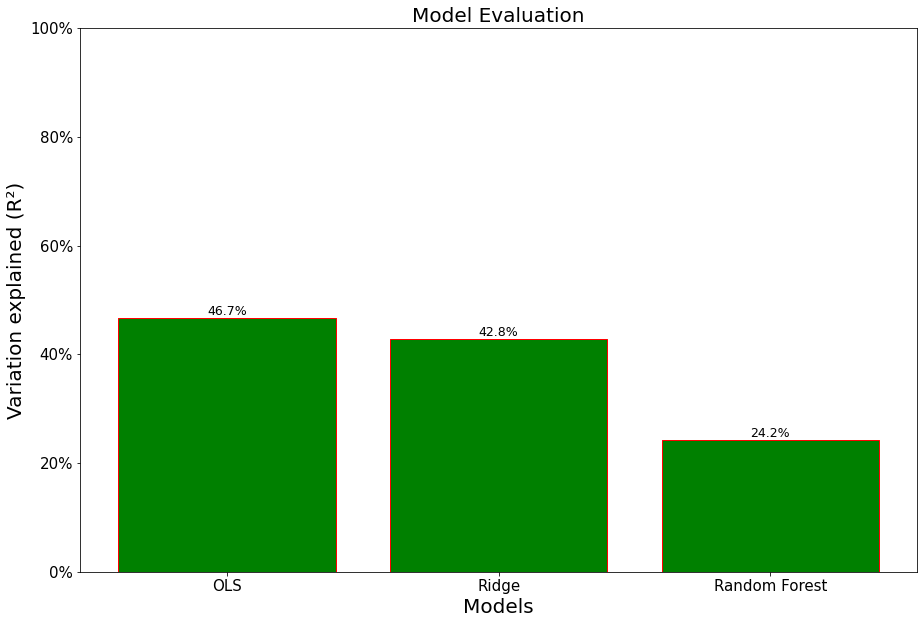

In [17]:
x = ['OLS', 'Ridge', 'Random Forest']
y = [46.7, 42.8, 24.2]

# plt.style.use('green')

fig, ax = plt.subplots(figsize=(15,10))
ax.yaxis.set_major_formatter(PercentFormatter())
bars = ax.bar(x, y, color=['green'],  edgecolor='red')
# ax.xticks()
ax.set_xlabel('Models', fontsize = 20)
ax.set_ylabel('Variation explained (R\u00b2)', fontsize = 20)
ax.set_ylim(0, 100)
ax.set_xticklabels(x, fontsize= 15)
ax.set_title('Model Evaluation', fontsize= 20)
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s=f'{height}%', ha='center',
  va='bottom', fontsize = 12.5)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

plt.show()
# fig.savefig("abc.png")
# files.download("abc.png") 

We are going to continue the analysis in the 'PredictingTimeSeries_Industry' notebook. 